<img src='https://unlearning-challenge.github.io/Unlearning-logo.png' width='100px'>

# NeurIPS 2023 Machine Unlearning Challenge Starting Kit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/unlearning-challenge/starting-kit/main/unlearning-CIFAR10.ipynb)


This notebook is part of the starting kit for the [NeurIPS 2023 Machine Unlearning Challenge](https://unlearning-challenge.github.io/). This notebook explains the pipeline of the challenge and contains sample unlearning and evaluation code.


This notebook has 3 sections:

  * 💾 In the first section we'll load a sample dataset (CIFAR10) and pre-trained model (ResNet18).

  * 🎯 In the second section we'll develop the unlearning algorithm. We start by splitting the original training set into a retain set and a forget set. The goal of an unlearning algorithm is to update the pre-trained model so that it approximates as much as possible a model that has been trained on the retain set but not on the forget set. We provide a simple unlearning algorithm as a starting point for participants to develop their own unlearning algorithms.

  * 🏅 In the third section we'll score our unlearning algorithm using a simple membership inference attacks (MIA). Note that this is a different evaluation than the one that will be used in the competition's submission.
  

We emphasize that this notebook is provided for convenience to help participants quickly get started. Submissions will be scored using a different method than the one provided in this notebook on a different (private) dataset of human faces. To run the notebook, the requirement is to have installed an up-to-date version of Python and Pytorch.

In [1]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

from tqdm import tqdm
from util import *
from function import *
from unlearn import *
import time
import torchvision.transforms as transform

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

/home/tianqi/anaconda3/envs/unlearning/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/tianqi/anaconda3/envs/unlearning/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Running on device: CUDA


# 💾 Download dataset and pre-trained model

In this section, we'll load a sample dataset (CIFAR-10), a pre-trained model (ResNet18) trained on CIFAR-10, plot some images and compute the accuracy of the model on the test set.

In [2]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #表示在图像周围填充 4 个像素，然后再进行随机裁剪，增加模型对边界的鲁棒性。
    transforms.RandomHorizontalFlip(), #是一个随机水平翻转的操作，它以给定的概率（默认是0.5）随机地水平翻转图像
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)



# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
N = len(held_out)
lengths = [N // 2, N - N // 2]
test_set, val_set = torch.utils.data.random_split(held_out, lengths, generator=RNG)

# test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

Files already downloaded and verified
Files already downloaded and verified


We'll now download the weights of the model trained in CIFAR-10 and load them in a Pytorch model. This model has been trained using SGD with a learning rate of 0.1, momentum of 0.9 and weight decay of 5e-4. It was also trained using data augmentation. In particular, the transforms used to the data were:

```python
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
```


In [3]:
# download pre-trained weights
local_path = "weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
time.sleep(1)
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")
time.sleep(1)




Train set accuracy: 99.5%


Test set accuracy: 88.3%


# 🎯 Unlearning Algorithm
In this section we develop the unlearning algorithm.

In the previous section we created a split of the original training set into a retain set and a forget set. Typically, the retain set is much larger than the forget set. Here, we produce a split that is 10% forget set, and 90% retain set.

The goal of an unlearning algorithm is to produce a model that approximates as much as possible the model trained solely on the retain set.

Below is a simple unlearning algorithm provided for illustration purposes. We call this algorithm unlearning by fine-tuning. It starts from the pre-trained model and optimizes it for a few epochs on the retain set. This is a very simple unlearning algorithm, but it is not very computationally efficient, and we don't expect it to work very well for most metrics.

To make a new entry in the competition, participants will submit an unlearning function with the same API as the one below. Note that the unlearning function takes as input a pre-trained model, a retain set, a forget set and an evaluation set (even though the fine-tuning algorithm below only uses the retain set and ignores the other datasets).


In [5]:
ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)
ft_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# ft_model = unlearning_fine_tune(ft_model, retain_loader, forget_loader, test_loader, epochs=5)
# # save checkpoint
# checkpoint_dir = "check_point_unlearn"
# checkpoint_path = os.path.join(checkpoint_dir, f"epoch_tune5.pth")
# torch.save(ft_model.state_dict(), checkpoint_path)

In [6]:
# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
ft_model = unlearning_blur(ft_model, retain_loader, forget_loader, test_loader, epochs=1)
# save checkpoint
checkpoint_dir = "check_point_unlearn"
checkpoint_path = os.path.join(checkpoint_dir, f"epoch_blur1.pth")
torch.save(ft_model.state_dict(), checkpoint_path)

In [7]:
ft_model = unlearning_fine_tune(ft_model, retain_loader, forget_loader, test_loader, epochs=1)
# save checkpoint
checkpoint_dir = "check_point_unlearn"
checkpoint_path = os.path.join(checkpoint_dir, f"epoch_blur1_tune1.pth")
torch.save(ft_model.state_dict(), checkpoint_path)

In [8]:
ft_model = unlearning_fine_tune(ft_model, retain_loader, forget_loader, test_loader, epochs=1)
# save checkpoint
checkpoint_dir = "check_point_unlearn"
checkpoint_path = os.path.join(checkpoint_dir, f"epoch_blur1_tune2.pth")
torch.save(ft_model.state_dict(), checkpoint_path)

# 🏅 Evaluation

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA). We provide this simple MIA for convenience so that participants can quickly obtain a metric for their unlearning algorithm, but submissions will be scored using a different method.

This MIA consists of a [logistic regression model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that predicts whether the model was trained on a particular sample from that sample's loss. To get an idea on the difficulty of this problem, we first plot below a histogram of the losses of the pre-trained model on the train and test set

In [10]:
train_losses = compute_losses(model, train_loader)
time.sleep(1)
test_losses = compute_losses(model, test_loader)


As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [11]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.580 on forgotten vs unseen images


We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [12]:
ft_forget_losses = compute_losses(ft_model, forget_loader)
ft_test_losses = compute_losses(ft_model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [13]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.506 on forgotten vs unseen images


From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

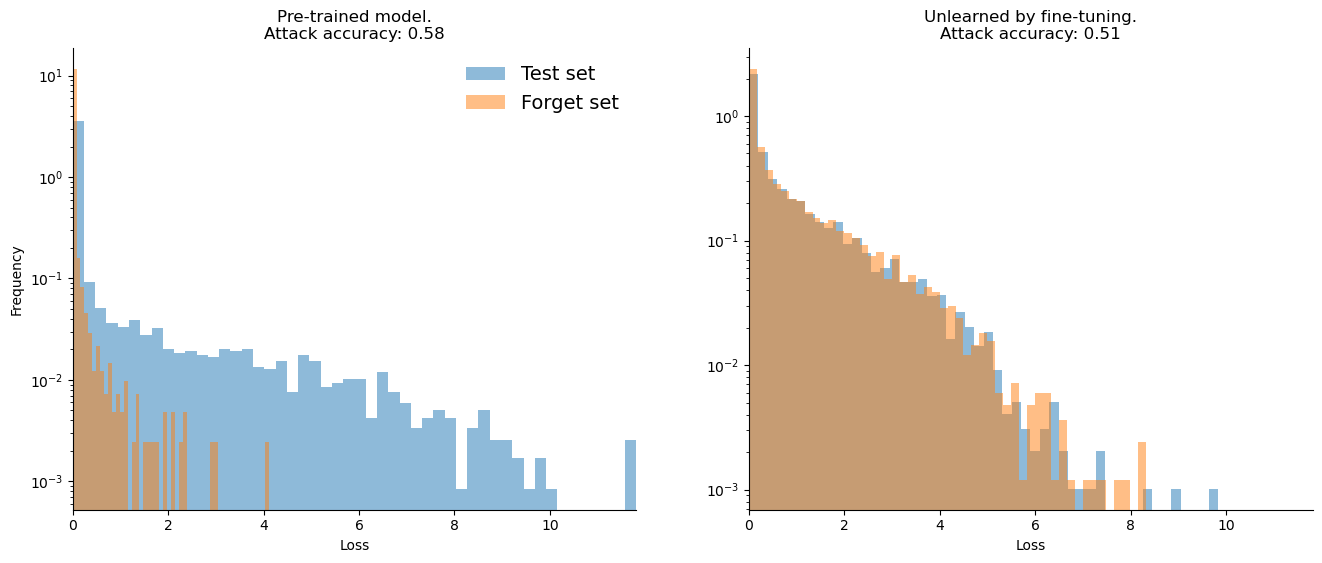

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Comparison with a re-trained model

One might ask, how good are the scores above? What is the best score? Since our goal is to approximate the model that has been trained only on the retain set, we'll consider that the gold standard is the score achieved by this model. Intuitively, we expect the MIA accuracy to be around 0.5, since for such a model, both the forget and test set are unseen samples from the same distribution. However, a number of factors such as distribution shift or class imbalance can make this number vary.

We'll now compute this score. We'll first download the weights for a model trained exclusively on the retain set and then compute the accuracy of the simple MIA.

In [15]:
# download weights of a model trained exclusively on the retain set
local_path = "retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
time.sleep(1)
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

Retain set accuracy: 99.5%


Forget set accuracy: 88.2%


As expected, the model trained exclusively on the retain set has a higher accuracy on the retain set than on the forget set (whose accuracy is similar than on the test set)

In [16]:
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [17]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.501 on forgotten vs unseen images


As we expect, the accuracy of the MIA attack is roughly 0.5. Finally, as we've done before, let's compare the histograms of this ideal algorithm (re-trained model) vs the model obtain from

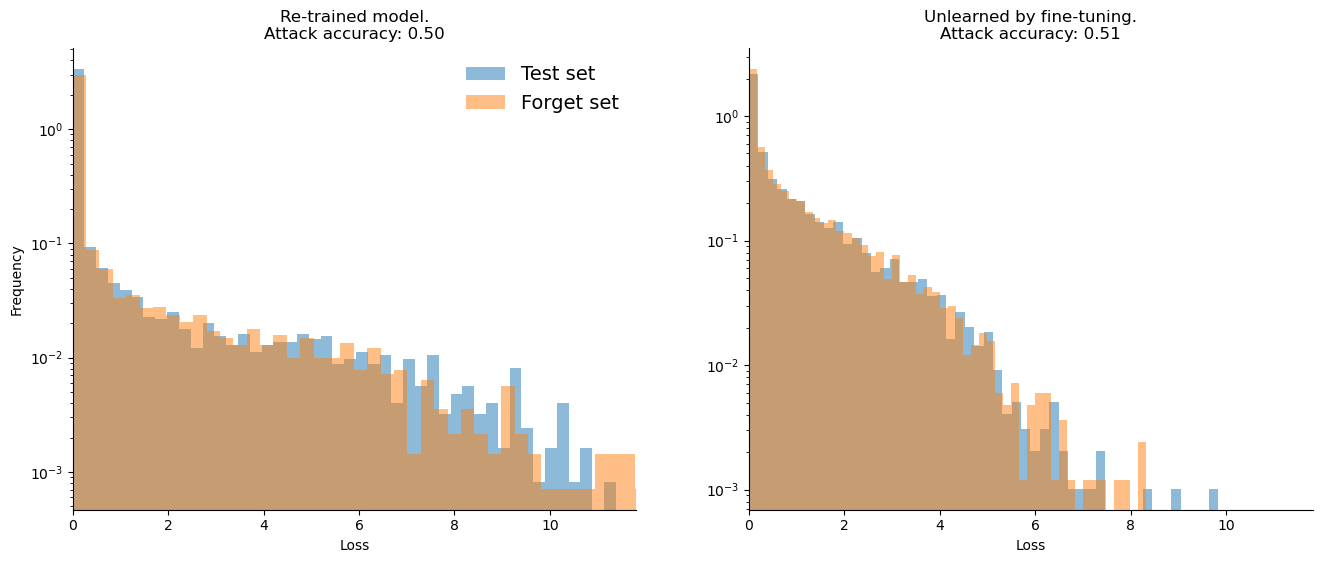

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()